# Adaptive RAG with Pathway

This notebook shows how you can **dynamically adapt the number of documents in a RAG prompt** using feedback from the LLM. This can give you [significant cost reduction](https://pathway.com/developers/showcases/adaptive-rag) of RAG LLM question answering while maintaining good accuracy. 

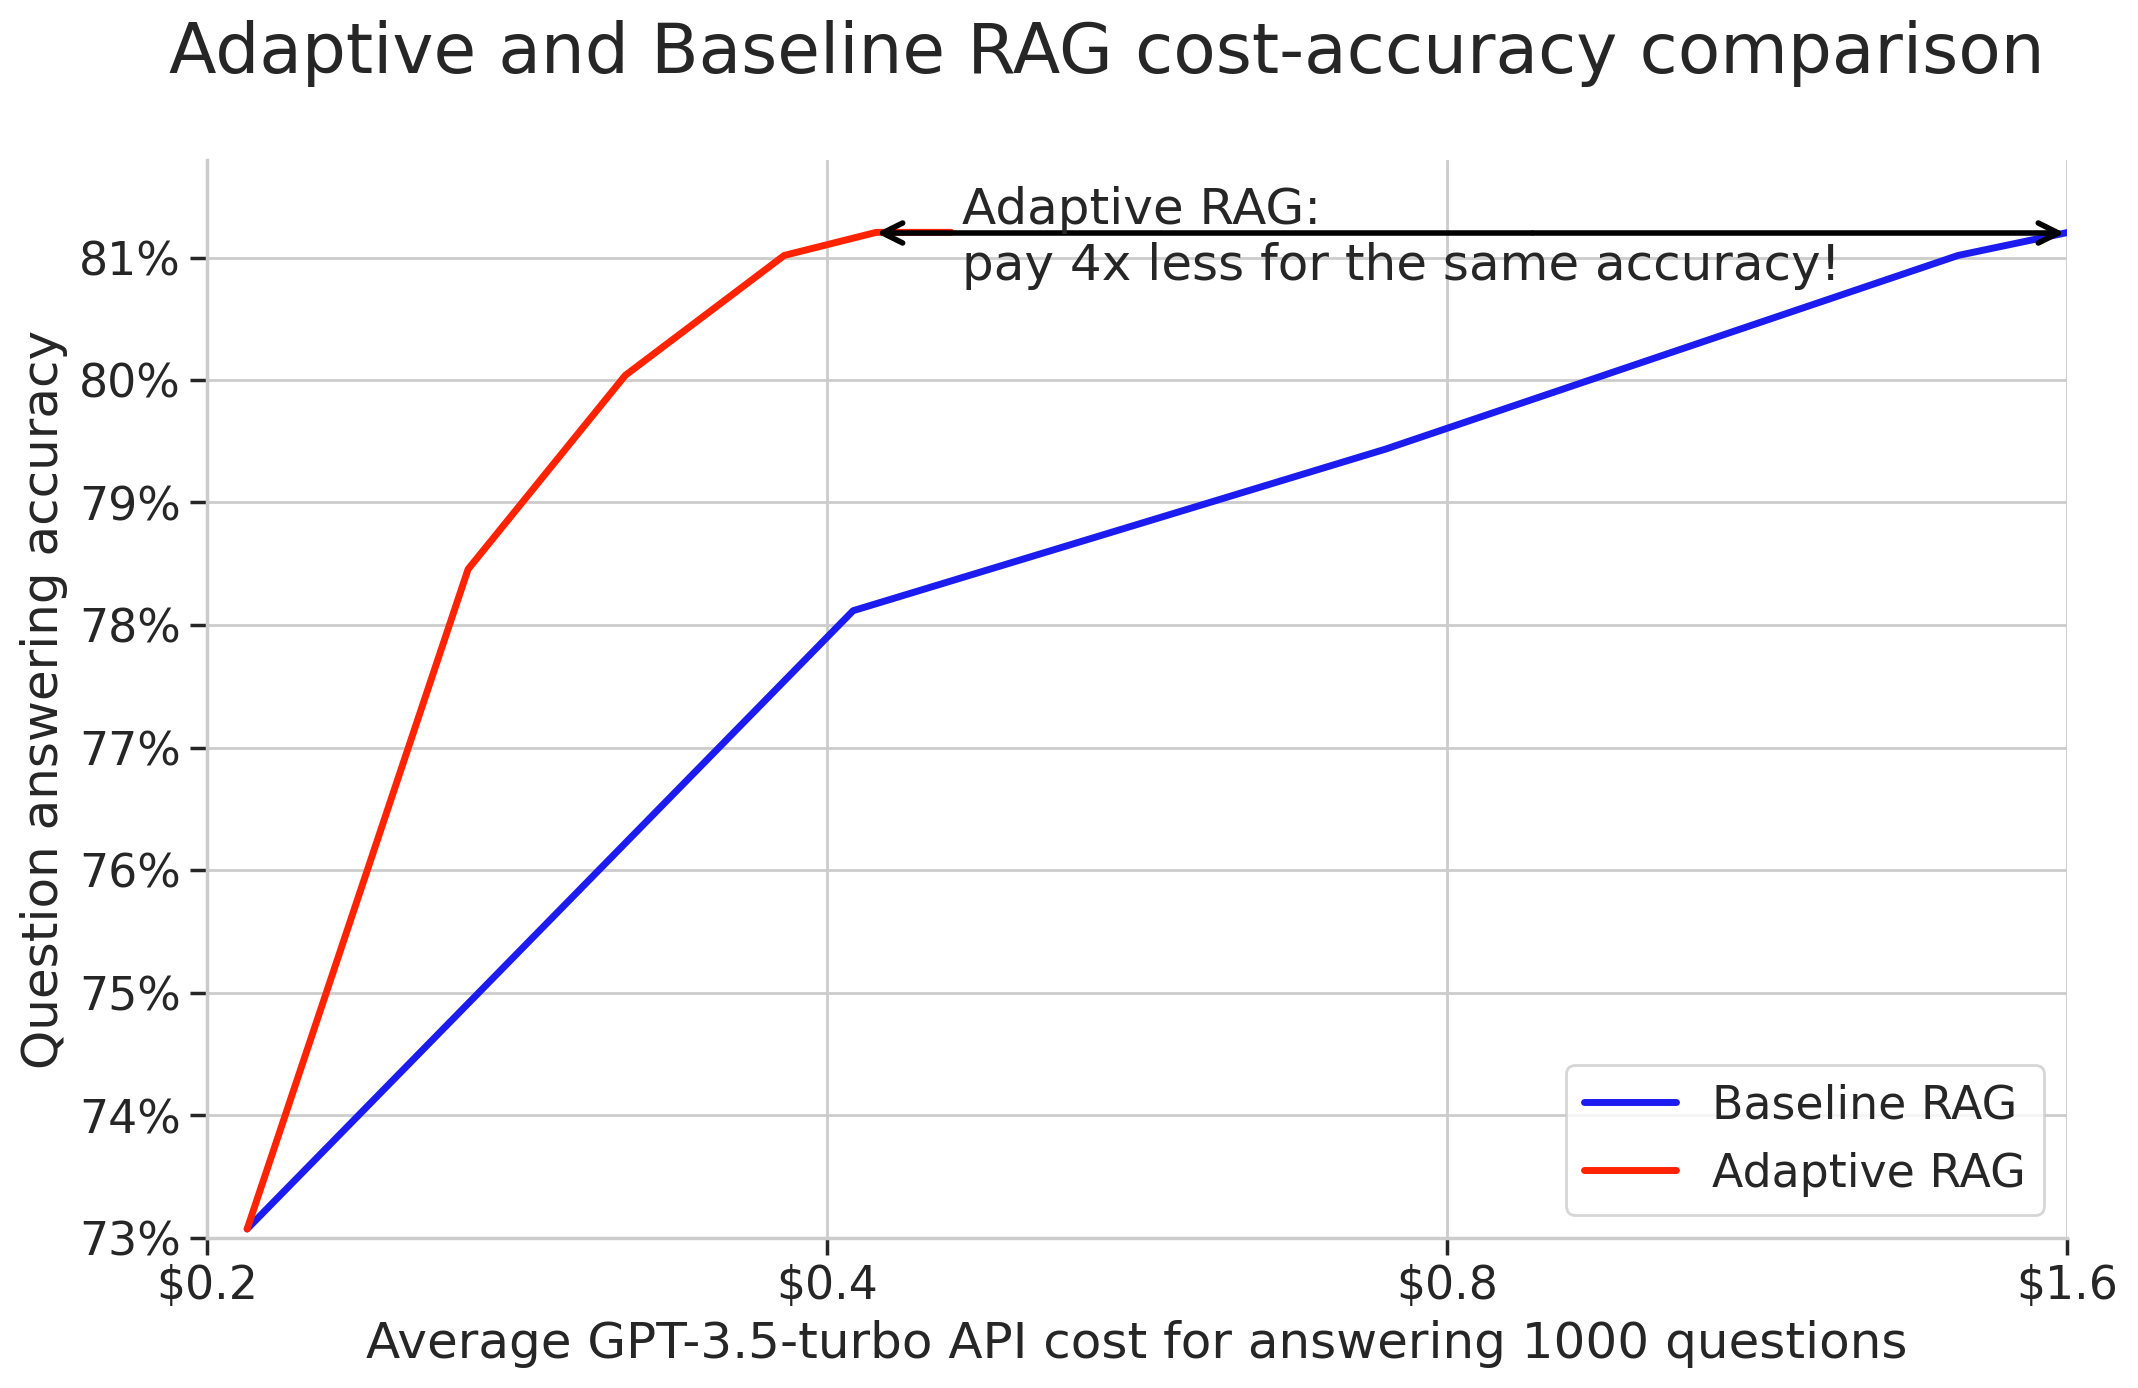


## Setup

### Using APIs 

* You will need a Mistral subscription to access the Mistral API.
* Create an account and fetch your API Key
* Pass the API Key into the prompt in this notebook or set it as environment variable `MISTRAL_API_KEY`

### Use Cache
If you want to use caching, set the `PATHWAY_PERSISTENT_STORAGE environmental variable:

In [ ]:
# # Uncomment and run if you want to use cache
# !export PATHWAY_PERSISTENT_STORAGE=".cache"

### Installing Libraries
You will need to have `pathway` and `mistralai` installed in your environment:

In [ ]:
# # Uncomment and run if you need to install Pathway and Mistral packages
# !pip install -U --prefer-binary pathway 
# !pip install "litellm<=1.35"
# !pip install mistralai

### Accessing Data
This notebook uses a sample JSON dataset with ~1000 context from the [SQUAD]() dataset. You can access it from the `data` directory or download it to your own machine using the code below. If you download it to another directory, make sure to update the path in the `documents = pw.io.fs.read(...)` call below.

In [ ]:
# # Download `adaptive-rag-contexts.jsonl` with ~1000 contexts from SQUAD dataset
# !wget -q -nc https://public-pathway-releases.s3.eu-central-1.amazonaws.com/data/adaptive-rag-contexts.jsonl

### Running locally
If you want to run this locally (e.g., on your laptop), use [Ollama](https://ollama.ai/library/mistral/tags):

* Download [Ollama app](https://ollama.ai/).
* Download a `Mistral` model e.g., `ollama pull mistral:instruct`, from various Mistral versions [here](https://ollama.ai/library/mistral) and Mixtral versions [here](https://ollama.ai/library/mixtral) available.
* Set flags indicating we will run locally and the Mistral model downloaded:

In [ ]:
# Flags for running locally
run_local = "Yes"
local_model = "ollama/mistral:instruct"

## Adaptive RAG Intuition

RAG question-answering applications involve an important trade-off regarding the context size. A large number of documents increases the ability of the LLM to provide a correct answer, but also increases LLM costs, which typically grow linearly with the length of the provided prompt. However, intuitively not all questions are equally hard and some can be answered using a small number of supporting documents, while some may require the LLM to consult a larger prompt. 

This is where **Adaptive RAG** comes in: 
1. start by asking the model to answer a question using a small number of documents.
2. If it refuses to answer, we will increase the context size.
3. We will do this iteratively until the model returns an answer. 

This improves the efficiency of our LLM pipeline. For most queries a single (cheap!) LLM call will be sufficient. A fraction of more complicated questions will require re-asking.

## Implementing Adaptive RAG

Let's implement Adaptive RAG by:
1. defining Mistral embedder and LLM
2. loading our context documents
3. defining our queries
4. running Adaptive RAG
5. inspecting the results

Start by importing the necessary libraries:

In [ ]:
import getpass
import os

import pandas as pd

# import litellm
# litellm.set_verbose = True

import pathway as pw
from pathway.stdlib.indexing import VectorDocumentIndex
from pathway.xpacks.llm.embedders import LiteLLMEmbedder, SentenceTransformerEmbedder 
from pathway.xpacks.llm.llms import LiteLLMChat  
from pathway.xpacks.llm.question_answering import (
    answer_with_geometric_rag_strategy_from_index,
)

Then define your Mistral embedder and LLM. If you want to run locally with Ollama, make sure to set the correct flags at the top of this notebook.

If you are not running locally and have not set the `MISTRAL_API_KEY` environment variable then the following cell will prompt you to securely pass your Mistral API Key.

*Note that for the local model:*
- we provide tested options for local embedders
- we specifically instruct the LLM to return json, which allows the LLM to follow the instructions more strictly.*

In [ ]:
# Check API key
if run_local == "Yes":
    pass
elif "MISTRAL_API_KEY" in os.environ:
    mistral_api_key = os.environ["MISTRAL_API_KEY"]
else:
    mistral_api_key = getpass.getpass("Mistral API Key:")

# Set config options
embedding_dimension: int = 1024

# choose embedder
large_model = "mixedbread-ai/mxbai-embed-large-v1"
medium_model = "avsolatorio/GIST-Embedding-v0"
small_model = "avsolatorio/GIST-small-Embedding-v0"

# define Mistral embedder
if run_local == "Yes":
    embedder = SentenceTransformerEmbedder(small_model, call_kwargs={"show_progress_bar": False})  # disable verbose logs
else:
    embedder = LiteLLMEmbedder(
        capacity = 5, 
        retry_strategy = pw.udfs.FixedDelayRetryStrategy(),
        model = "mistral/mistral-embed",
        api_key=mistral_api_key,
    )

# define Mistral LLM
if run_local == "Yes":
    model = LiteLLMChat(
        model=local_model, 
        temperature=0,
        top_p=1,
        format="json",  # only available in Ollama local deploy, not usable in Mistral API
    )
else:
    model = LiteLLMChat(
        model="mistral/mistral-large-latest", 
        temperature=0, 
        api_key=mistral_api_key,
        top_p=1
    )

Next, let's load the context documents and create a table with our queries:

In [ ]:
# Load documents in which answers will be searched
class InputSchema(pw.Schema):
    doc: str

documents = pw.io.fs.read(
    "data/adaptive-rag-contexts.jsonl",
    format="json",
    schema=InputSchema,
    json_field_paths={"doc": "/context"},
    mode="static",
)

# Create table with questions
df = pd.DataFrame(
    {
        "query": [
            "When it is burned what does hydrogen make?",
            #"When did Arnold switch from acting to politics?"
            "What was undertaken in 2010 to determine where dogs originated from?"
            #"What is a common nickname used to refer to dogs across multiple languages?",
        ]
    }
)
query = pw.debug.table_from_pandas(df)

Now let's create a Vector index of the documents and set up our Adaptive RAG:

In [ ]:
# Index for finding closest documents
index = VectorDocumentIndex(
    documents.doc, documents, embedder, n_dimensions=embedding_dimension
)

# Run Adaptive RAG
result = query.select(
    question=query.query,
    result=answer_with_geometric_rag_strategy_from_index(
        query.query, #define query
        index, #pass index
        documents.doc, #define context docs
        model, #define LLM
        n_starting_documents=2, #set number of docs to include in first query iteration
        factor=2, #set factor to increase n_docs with
        max_iterations=4, #set max number of iterations,
        strict_prompt=True,  # needed for open source models, instructs LLM to give JSON output strictly
    ),
)

Run the cell below to execute Adaptive RAG and fetch the results: 

In [ ]:
responses_df = pw.debug.table_to_pandas(result)

In [ ]:
print(responses_df["result"].iloc[0])
print(responses_df["result"].iloc[1])

## References

Read more about [the technical implementation and benchmarking](https://pathway.com/developers/showcases/adaptive-rag) of Adaptive RAG.